(17868, 128) (7658, 128) (17868,) (7658,)
training accuracy 0.6673979471910992
[[2.67857185e-02 1.59339445e-01 2.64003281e-05 ... 3.60003919e-04
  2.22971538e-03 2.29395823e-03]
 [1.63860992e-02 2.13518183e-03 1.62048241e-01 ... 6.44339945e-03
  7.43152310e-03 2.61787288e-03]
 [1.95907600e-03 2.23253956e-03 8.57379123e-01 ... 4.35363143e-04
  2.46461872e-03 3.53760845e-03]
 ...
 [4.03176743e-02 5.14309549e-02 3.86226328e-02 ... 9.17070816e-03
  3.31579138e-02 4.63407953e-02]
 [6.66224449e-02 1.48714213e-02 1.21939092e-01 ... 6.42813456e-03
  2.13773279e-03 3.95987672e-03]
 [6.35902165e-03 2.07662746e-02 8.71299986e-02 ... 7.96051485e-04
  1.72667463e-01 1.70575075e-01]]
(3000, 15)
[ 1  3  4  5  6  7  9 10 11 13 15 16 17 18 19]


[1800 1800 1800 1800 1800 1800 1543 1345 1800 1782 1800 1800 1800 1056
 1800]
SVM: 


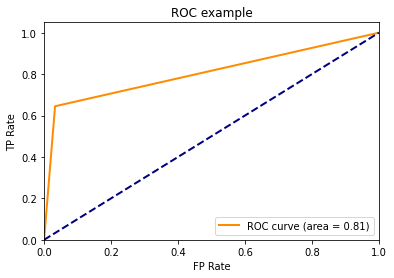

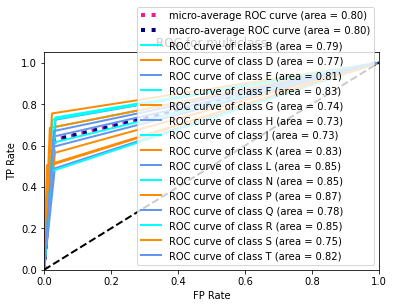

              precision    recall  f1-score   support

           0       0.59      0.61      0.60       200
           1       0.55      0.56      0.56       200
           2       0.58      0.65      0.61       200
           3       0.59      0.69      0.64       200
           4       0.65      0.51      0.57       200
           5       0.52      0.49      0.51       200
           6       0.63      0.47      0.54       200
           7       0.74      0.69      0.71       200
           8       0.60      0.72      0.66       200
           9       0.67      0.72      0.70       200
          10       0.70      0.76      0.72       200
          11       0.59      0.59      0.59       200
          12       0.61      0.73      0.67       200
          13       0.81      0.51      0.62       200
          14       0.62      0.67      0.64       200

    accuracy                           0.63      3000
   macro avg       0.63      0.63      0.62      3000
weighted avg       0.63   

In [3]:
# title + synopsis + Bert
import os
import os.path as path
import pickle
from typing import *
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.preprocessing import label_binarize # Binarize labels in a one-vs-all
import sklearn
from sklearn.metrics import roc_curve, auc
from scipy import interpolate
from itertools import cycle


class Record:
    def __init__(self, cls, title, synopsis, id):
        self.cls: str = cls
        self.title: str = title
        self.synopsis: str = synopsis
        self.id: int = id

        self.title_embeddings_bert: List[Any] = None
        self.synopsis_embeddings_bert: List[Any] = None

        self.title_embeddings_w2v: List[Any] = None  #
        self.synopsis_embeddings_w2v: List[Any] = None

    def __str__(self) -> str:
        return "class: {}, title: {}, id:{}, synopsis:{}".format(self.cls, self.title, self.id, self.synopsis)


class RecordStore:
    train_records: List[Record] = []
    test_records: List[Record] = []
    DATA_ROOT = "/content/embeddings"

    """
    Loads the records, without their embeddings. Should always be used before accessing any of the other functions 
    or properties of this class.
    """

    @staticmethod
    def load():
        with open(path.join(RecordStore.DATA_ROOT, 'trainTest.pk'), 'rb') as f:
            classes = pickle.load(f)
            train = pickle.load(f)
            test = pickle.load(f)

        RecordStore.train_records = [Record(cls, title, synopsis, id) for (cls, title, synopsis, id) in train]
        RecordStore.test_records = [Record(cls, title, synopsis, id) for (cls, title, synopsis, id) in test]


#    Loads the bert embededdings into memory. Only use if you need these embeddings.


    @staticmethod
    def load_bert(f):
        with open(path.join(RecordStore.DATA_ROOT, 'bert_train.pk'), 'rb') as f:
            [title_embeddings, synopsis_embeddings] = pickle.load(f)

        for i, record in enumerate(RecordStore.train_records):
            record.title_embeddings_bert = title_embeddings[i]
            record.synopsis_embeddings_bert = synopsis_embeddings[i]
            # print (i, record)

        with open(path.join(RecordStore.DATA_ROOT, 'bert_test.pk'), 'rb') as f:
            [title_embeddings, synopsis_embeddings] = pickle.load(f)

        for i, record in enumerate(RecordStore.test_records):
            record.title_embeddings_bert = title_embeddings[i]
            record.synopsis_embeddings_bert = synopsis_embeddings[i]
            # print (i, record)

"""
train and validation and hyper-parameters tuning with a separate validation set
"""
# train and validate (a separate validation set) an SVM multiclass classification model with "one-vs-rest" classifier
def svm_validation(x_train, y_train, x_validation, y_validation):
    best_score = -1
    best_svm = None
    C = [10, 100]
    kernel = ["rbf"]
    gamma = [0.001, 0.0001]
    hyperparam_list = []
    for i in C:
        for j in gamma:
            hyperparam_list.append({"C": i,"gamma": j})
    #print(hyperparam_list)

    for parameters in hyperparam_list:
        model_mc_svm = OneVsRestClassifier(SVC(C=parameters["C"],
                                               kernel="rbf",
                                               gamma=parameters["gamma"],
                                               random_state=7)
                                           )
    # train
    model_mc_svm.fit(x_train, y_train)

    # validation
    model_mc_svm.predict(x_validation)
    # calculate the mean accuracy for each model
    mean_accuracy = model_mc_svm.score(x_validation, y_validation)
    # print results
    print("estimator__C: {}, estimator__gamma: {}, mean_accuracy: {:.4f}".format(
        str(parameters["C"]), parameters["gamma"],mean_accuracy))
    if mean_accuracy > best_score: best_score = mean_accuracy; best_svm = model_mc_svm
    # print best results


    print("best_parameters:")
    print("best_svm: {}, best_score: {}".format(
        best_svm,
        best_score))
    return best_svm, best_score

'''
ROC curve
'''
# A lot of the code for this function was borrowed from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
def roc(y_test, y_score):
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  # Compute micro-average ROC curve and ROC area
  fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

  plt.figure()
  lw = 2
  plt.plot(
      fpr[2],
      tpr[2],
      color="darkorange",
      lw=lw,
      label="ROC curve (area = %0.2f)" % roc_auc[2],
  )
  plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel("FP Rate")
  plt.ylabel("TP Rate")
  plt.title("ROC example")
  plt.legend(loc="lower right")
  plt.show()

  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(n_classes):
      mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

  # Finally average it and compute AUC
  mean_tpr /= n_classes

  fpr["macro"] = all_fpr
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

  # Plot all ROC curves
  plt.figure()
  plt.plot(
      fpr["micro"],
      tpr["micro"],
      label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
      color="deeppink",
      linestyle=":",
      linewidth=4,
  )
  plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
  )

  colors = cycle(["aqua", "darkorange", "cornflowerblue"])
  for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(chr(classes[i]+65), roc_auc[i]),
    )

  plt.plot([0, 1], [0, 1], "k--", lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel("FP Rate")
  plt.ylabel("TP Rate")
  plt.title("ROC for multiclass")
  plt.legend(loc="lower right")
  plt.show()

"""
confusion matrix
"""
def other_metrics(y_test, y_score):
  y_pred=np.argmax(y_score, axis=1)
  y_test=np.argmax(y_test, axis=1)
  # Classification report
  cr = metrics.classification_report(y_pred=y_pred, y_true=y_test)
  print(cr)
  # Confusion matrix
  cm = metrics.confusion_matrix(y_pred=y_pred, y_true=y_test)
  print("\nConfusion matrix:\n%s" % cm)
  acc = metrics.accuracy_score(y_pred, y_test)
  print("Accuracy: ", acc)
  precision = metrics.precision_score(y_test, y_pred,average ='weighted')
  print("Precision: ", precision)
  recall = metrics.recall_score(y_test, y_pred, average = 'weighted')
  print("Recall: ", recall)

'''
other metrics
'''
def performance_metrics(y_test, y_score):
  roc(y_test, y_score)
  other_metrics(y_test, y_score)


def main():
#    train_data_title = np.zeros([25526, 128])
#    train_data_synopsis = np.zeros([25526, 128])
    train_data_title = np.zeros([25526, 128])
    train_data_synopsis = np.zeros([25526, 128])

    test_data_title = np.zeros([3000, 128])
    test_data_synopsis = np.zeros([3000, 128])

    train_labels = []
    test_labels= []


    RecordStore.load()
    RecordStore.load_bert('bert_train.pk')
#    for i in range(len(RecordStore.train_records)):
    for i in range(25526):
        train_data_title[i] = np.mean(RecordStore.train_records[i].title_embeddings_bert, axis=0)
        train_data_synopsis[i] = np.mean(RecordStore.train_records[i].synopsis_embeddings_bert, axis=0)
        train_labels.append(ord(RecordStore.train_records[i].cls)-65)
#        train_labels.append(RecordStore.train_records[i].cls)
    train_labels = np.array(train_labels) # (25526,)

    for i in range(len(RecordStore.test_records)):
        test_data_title[i] = np.mean(RecordStore.test_records[i].title_embeddings_bert, axis=0)
        test_data_synopsis[i] = np.mean(RecordStore.test_records[i].synopsis_embeddings_bert, axis=0)
        test_labels.append(ord(RecordStore.test_records[i].cls) - 65)
#        test_labels.append(RecordStore.test_records[i].cls)
    test_labels = np.array(test_labels) # (3000,)


    # split validation set from train set with 30:70 ratio
    x_train, x_validation, y_train, y_validation = train_test_split(train_data_synopsis, train_labels, test_size=0.3, random_state=123)
    print(np.shape(x_train), np.shape(x_validation), np.shape(y_train), np.shape(y_validation)) # (17868, 256) (7658, 256) (17868,) (7658,)

    '''
    Validation to tuning hyper-parameters
    Best Parameters: C: 100, gamma: 0.0001, mean_accuracy: 0.5881
    '''
#    best_svm, best_score= svm_validation(x_train, y_train, x_validation, y_validation)


    # specify a model with the best hyperparameters
    model_mc_svm = OneVsRestClassifier(SVC(C=100,
                                           kernel="rbf",
                                           gamma=0.001,
                                           probability=True,
                                           random_state=7)
                                       )
    # fit the model on the whole training set (before split the validation set)
    model_mc_svm.fit(train_data_synopsis, train_labels)
    accuracy = model_mc_svm.score (train_data_synopsis, train_labels)
    print('training accuracy', accuracy)
    

    
    # predict the test target with the optimized model
    y_pred_svm = model_mc_svm.predict_proba(test_data_synopsis)  # returns probability of being in each class (3000 * 15 matrix?)
    print (y_pred_svm)
    print (np.shape(y_pred_svm))


    y_pred_svm_argmax = []
    for i in range(y_pred_svm.shape[0]):
        y_pred_svm_argmax.append(classes[int(np.argmax([y_pred_svm[i]]))])  # find the predicted class

    # transform the labels and predicted class to one-hot encoding
    freq = np.bincount(test_labels) # test_labels[ 1  3  4  5  6  7  9 10 11 13 15 16 17 18 19]
    unique, counts = np.unique(train_labels, return_counts=True)
    print (unique) # 
    print ("\n")
    print (counts)

    # one-hot encode labels and predicted class
    y_test = label_binarize(test_labels, classes=classes)
    y_pred_svm = label_binarize(y_pred_svm_argmax, classes=classes)

    # final output
    print("SVM: ")
    performance_metrics(y_test, y_pred_svm)

classes = [1,3,4,5,6,7,9,10,11,13,15,16,17,18,19]
n_classes = len(classes)
label_list = []

main()


#    print("\n")
#    print(train_labels[1]) # N
#    print(type(train_labels)) # <class 'numpy.ndarray'>
#    print("\n")
#    print(train_data_title[1]) #  array of 128 elements for record #1
#    print(train_data_synopsis[1]) #  array of 128 elements per record #1
#    print("\n")
#    print(np.shape(train_data_title)) #(25526, 128) # take an average of _embeddings_bert and collapsed the lower dimension (13-- # tokens which varies across records) per records
#    print(np.shape(train_data_synopsis)) # (2256, 128) # take an average of _embeddings_bert and collapsed the lower dimension (24)
#    print("\n")
#    print(RecordStore.train_records[1].title_embeddings_bert)
#    print(RecordStore.train_records[1].synopsis_embeddings_bert)
#    print("\n")
#    print(np.shape(RecordStore.train_records[1].title_embeddings_bert)) # (13, 128)
#    print(np.shape(RecordStore.train_records[1].synopsis_embeddings_bert)) # (24, 128)
#    print("\n")
#    print(RecordStore.train_records[1].title)
#    print(RecordStore.train_records[1].synopsis)
    #  print (type(RecordStore.train_records[25525].title_embeddings_bert))#np.array
    #  print(RecordStore.train_records[:25525].cls)
    #  print(RecordStore.train_records[25525].title_embeddings_bert.shape())



